<a href="https://colab.research.google.com/github/p-pradhyumna/Data-Science/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy matplotlib scikit-learn


In [2]:
pip install seaborn


In [3]:
from google.colab import files
uploaded = files.upload()  # Upload your CSV files


Saving Transactions.csv to Transactions.csv
Saving Products.csv to Products.csv
Saving Customers.csv to Customers.csv


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets
data = customers.merge(transactions, on='CustomerID', how='left')

# Aggregate transaction data at the customer level
customer_features = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'Price': 'mean',
    'Region': 'first'
}).reset_index()

# Normalize numerical features
scaler = StandardScaler()
numerical_cols = ['Quantity', 'TotalValue', 'Price']
customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])

# Encode categorical features
encoder = LabelEncoder()
customer_features['Region'] = encoder.fit_transform(customer_features['Region'])


In [5]:
print(customer_features.isnull().sum())


CustomerID    0
Quantity      0
TotalValue    0
Price         1
Region        0
dtype: int64


In [6]:
customer_features.fillna(0, inplace=True)


In [7]:
print(customer_features.isnull().sum().sum())  # Should return 0


0


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Store clustering results and DBI scores
db_scores = []
k_values = range(2, 11)

# Perform clustering for k=2 to k=10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(customer_features.drop('CustomerID', axis=1))
    customer_features[f'Cluster_k{k}'] = clusters

    # Compute Davies-Bouldin Index
    db_score = davies_bouldin_score(customer_features.drop('CustomerID', axis=1), clusters)
    db_scores.append(db_score)
    print(f"Number of Clusters: {k}, DB Index: {db_score}")


Number of Clusters: 2, DB Index: 1.2679312079507368
Number of Clusters: 3, DB Index: 0.9986545962936267
Number of Clusters: 4, DB Index: 0.9715628413380206
Number of Clusters: 5, DB Index: 0.8090554103495144
Number of Clusters: 6, DB Index: 0.6398847546634334
Number of Clusters: 7, DB Index: 0.5395261245311725
Number of Clusters: 8, DB Index: 0.4555346954555644
Number of Clusters: 9, DB Index: 0.40461746658166864
Number of Clusters: 10, DB Index: 0.3474024589113427


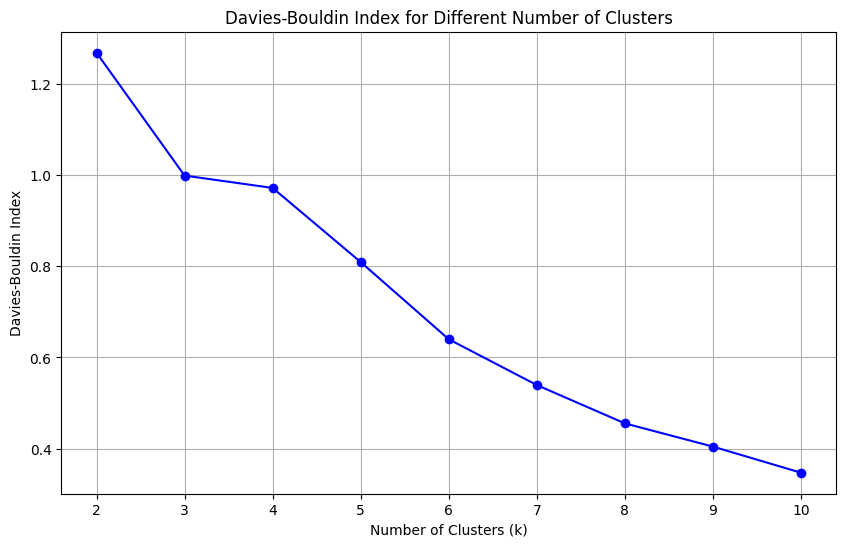

In [9]:
import matplotlib.pyplot as plt

# Plot DBI scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_scores, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index for Different Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.grid()
plt.show()


In [11]:
# Assign clusters based on optimal k
optimal_k = 3  # Replace this with the best k from your DBI evaluation
customer_features['Final_Cluster'] = customer_features[f'Cluster_k{optimal_k}']

# Save clustering results to CSV
customer_features[['CustomerID', 'Final_Cluster']].to_csv('Customer_Segmentation.csv', index=False)
print("Clustering results saved to 'Customer_Segmentation.csv'")


Clustering results saved to 'Customer_Segmentation.csv'


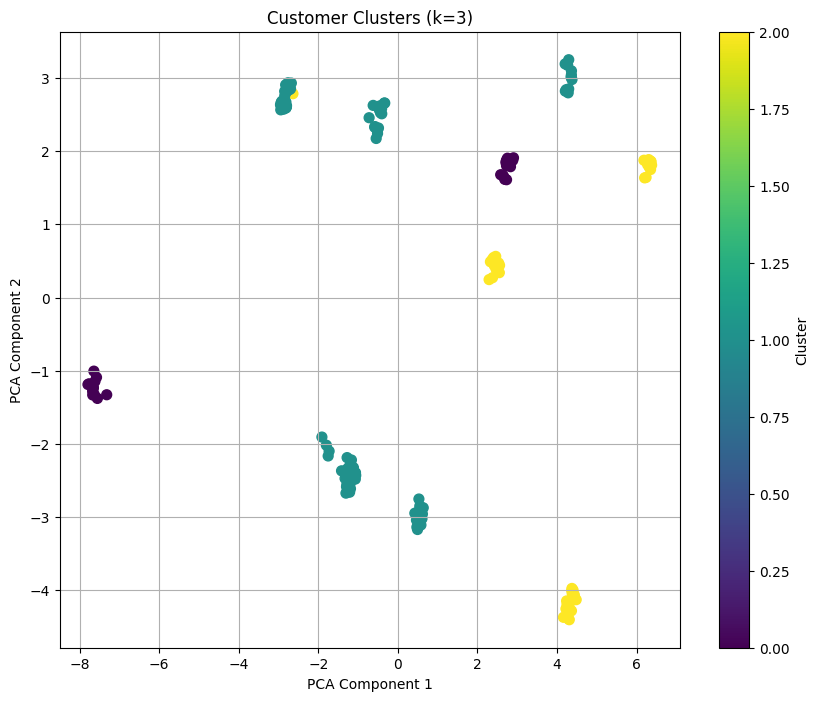

In [12]:
from sklearn.decomposition import PCA

# Reduce to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(customer_features.drop(['CustomerID', 'Final_Cluster'], axis=1))

# Plot the clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=customer_features['Final_Cluster'], cmap='viridis', s=50)
plt.title(f'Customer Clusters (k={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()


In [13]:
print(customer_features.head())  # Inspect the first few rows
print(customer_features.dtypes)  # Check data types of each column


  CustomerID  Quantity  TotalValue     Price  Region  Cluster_k2  Cluster_k3  \
0      C0001 -0.110735   -0.051884  0.094670       3           1           2   
1      C0002 -0.434049   -0.862714 -0.904016       0           1           1   
2      C0003  0.212579   -0.393842 -1.094109       3           1           1   
3      C0004  1.667493    1.035375 -0.447702       3           0           2   
4      C0005 -0.919021   -0.769499  0.285581       0           1           1   

   Cluster_k4  Cluster_k5  Cluster_k6  Cluster_k7  Cluster_k8  Cluster_k9  \
0           1           1           3           1           1           1   
1           2           2           1           3           4           3   
2           1           1           3           1           1           1   
3           3           4           2           6           3           8   
4           2           2           1           3           4           3   

   Cluster_k10  Final_Cluster  
0            5          

In [14]:
# Exclude non-numeric columns
numeric_features = customer_features.select_dtypes(include=['number'])

# Group by 'Final_Cluster' and calculate the mean
cluster_summary = numeric_features.groupby(customer_features['Final_Cluster']).mean()
print(cluster_summary)


               Quantity  TotalValue     Price    Region  Cluster_k2  \
Final_Cluster                                                         
0              0.960820    1.063037  0.282033  0.485714    0.028571   
1             -0.595706   -0.647868 -0.189006  1.495868    1.000000   
2              0.873904    0.936040  0.295421  2.750000    0.159091   

               Cluster_k3  Cluster_k4  Cluster_k5  Cluster_k6  Cluster_k7  \
Final_Cluster                                                               
0                     0.0    0.057143    1.600000    2.200000    2.685714   
1                     1.0    1.520661    1.520661    2.785124    2.330579   
2                     2.0    2.954545    3.931818    2.022727    4.522727   

               Cluster_k8  Cluster_k9  Cluster_k10  Final_Cluster  
Final_Cluster                                                      
0                1.171429    3.200000     3.114286            0.0  
1                2.884298    3.223140     3.694215    

In [15]:
# Check for string values in numerical columns
for col in customer_features.columns:
    if customer_features[col].dtype == 'object':
        print(f"Column: {col}")
        print(customer_features[col].unique()[:5])  # Show unique values


Column: CustomerID
['C0001' 'C0002' 'C0003' 'C0004' 'C0005']


In [16]:
# Exclude non-numeric columns for aggregation
cluster_summary = customer_features.drop(['CustomerID'], axis=1).groupby('Final_Cluster').mean()

# Display the cluster summary
print("Cluster Summary:")
print(cluster_summary)


Cluster Summary:
               Quantity  TotalValue     Price    Region  Cluster_k2  \
Final_Cluster                                                         
0              0.960820    1.063037  0.282033  0.485714    0.028571   
1             -0.595706   -0.647868 -0.189006  1.495868    1.000000   
2              0.873904    0.936040  0.295421  2.750000    0.159091   

               Cluster_k3  Cluster_k4  Cluster_k5  Cluster_k6  Cluster_k7  \
Final_Cluster                                                               
0                     0.0    0.057143    1.600000    2.200000    2.685714   
1                     1.0    1.520661    1.520661    2.785124    2.330579   
2                     2.0    2.954545    3.931818    2.022727    4.522727   

               Cluster_k8  Cluster_k9  Cluster_k10  
Final_Cluster                                       
0                1.171429    3.200000     3.114286  
1                2.884298    3.223140     3.694215  
2                5.522727    

In [17]:
print("Cluster Sizes:")
print(customer_features['Final_Cluster'].value_counts())


Cluster Sizes:
Final_Cluster
1    121
2     44
0     35
Name: count, dtype: int64


In [19]:
# Save the final clustering results
customer_features[['CustomerID', 'Final_Cluster']].to_csv('Customer_Segmentation.csv', index=False)
print("Clustering results saved to 'Customer_Segmentation.csv'")


Clustering results saved to 'Customer_Segmentation.csv'
